In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from io import StringIO

In [8]:
file_path = r"/content/drive/MyDrive/Colab Notebooks/data/WISDM_ar_v1.1_raw.txt"
processedList = []
try:
    with open(file_path, encoding='utf-8', errors='ignore') as file:
        for i, line in enumerate(file):
            try:
                line = line.strip().split(',')
                # 마지막 필드에서 ';'를 제거하고 공백도 제거
                last_val = line[5].split(';')[0].strip()
                if last_val == '':
                    continue
                temp = [
                    int(line[0]),    # user_id
                    line[1],         # activity (string)
                    line[2],         # timestamp (string)
                    float(line[3]),  # x
                    float(line[4]),  # y
                    float(last_val)  # z
                ]
                processedList.append(temp)
            except (ValueError, IndexError) as e:
                # 데이터 형식이 잘못된 줄은 건너뛰기
                print(f'Error at line number: {i+1} -> {e}. Skipping this line.')
                continue
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")
    exit()

# 리스트를 DataFrame으로 변환
df = pd.DataFrame(processedList, columns=['user_id', 'activity', 'timestamp', 'accel_x', 'accel_y', 'accel_z'])

print("DataFrame loaded successfully. Displaying first 5 rows:")
print(df.head())
print("\nDataFrame info:")
df.info()


# subject-wise 데이터 분리
train_df = df[(df['user_id'] >= 1) & (df['user_id'] <= 20)]
val_df = df[(df['user_id'] >= 21) & (df['user_id'] <= 29)]
test_df = df[df['user_id'] >= 30]

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")



Error at line number: 281874 -> list index out of range. Skipping this line.
Error at line number: 281875 -> list index out of range. Skipping this line.
Error at line number: 281876 -> list index out of range. Skipping this line.
Error at line number: 537502 -> list index out of range. Skipping this line.
Error at line number: 832902 -> list index out of range. Skipping this line.
Error at line number: 1098210 -> list index out of range. Skipping this line.
DataFrame loaded successfully. Displaying first 5 rows:
   user_id activity       timestamp   accel_x    accel_y   accel_z
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098203 entr

In [9]:
# 윈도우 생성 함수
def create_windows(data, frame_size=200, hop_size=40):
    windows = []
    labels = []

    for user_id in data['user_id'].unique():
        user_data = data[data['user_id'] == user_id].copy()
        user_data.reset_index(drop=True, inplace=True)
        accel_data = user_data[['accel_x', 'accel_y', 'accel_z']].values

        # 데이터 길이가 윈도우 크기보다 작을 경우 처리
        if len(accel_data) < frame_size:
            continue

        for i in range(0, len(accel_data) - frame_size + 1, hop_size):
            window = accel_data[i:i + frame_size]
            label = user_data['activity'].iloc[i + frame_size // 2]
            windows.append(window)
            labels.append(label)

    return np.array(windows), np.array(labels)

X_train, y_train_labels = create_windows(train_df, frame_size=200, hop_size=40)
X_val, y_val_labels = create_windows(val_df, frame_size=200, hop_size=40)
X_test, y_test_labels = create_windows(test_df, frame_size=200, hop_size=40)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train_labels.shape}")

X_train shape: (15493, 200, 3)
y_train shape: (15493,)


In [10]:
# 스케일링
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_val_reshaped = X_val.reshape(-1, X_val.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

# 레이블 인코딩 및 원-핫 인코딩
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_labels)
y_val_encoded = label_encoder.transform(y_val_labels)
y_test_encoded = label_encoder.transform(y_test_labels)

y_train_onehot = to_categorical(y_train_encoded)
y_val_onehot = to_categorical(y_val_encoded)
y_test_onehot = to_categorical(y_test_encoded)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train_onehot shape: {y_train_onehot.shape}")

X_train_scaled shape: (15493, 200, 3)
y_train_onehot shape: (15493, 6)


In [11]:
# 모델 구축
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
num_classes = y_train_onehot.shape[1]

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 모델 학습
history = model.fit(
    X_train_scaled,
    y_train_onehot,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_onehot),
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 198, 64)        │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 97, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6144)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       614,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 640,450 (2.44 MB)

 Trainable params: 640,450 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7554 - loss: 0.6675 - val_accuracy: 0.7744 - val_loss: 0.8555
Epoch 2/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9492 - loss: 0.1416 - val_accuracy: 0.8031 - val_loss: 0.9068
Epoch 3/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9715 - loss: 0.0850 - val_accuracy: 0.8347 - val_loss: 0.9611
Epoch 4/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9840 - loss: 0.0511 - val_accuracy: 0.8426 - val_loss: 0.9530
Epoch 5/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.8097 - val_loss: 1.3085
Epoch 6/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.9893 - loss: 0.0342 - val_accuracy: 0.8305 - val_loss: 1.2831
Epoch 7/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9918 - loss: 0.0267 - val_accuracy: 0.8355 - val_loss: 1.2849
Epoch 8/20
485/485 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9950 - loss: 0.0177 - 

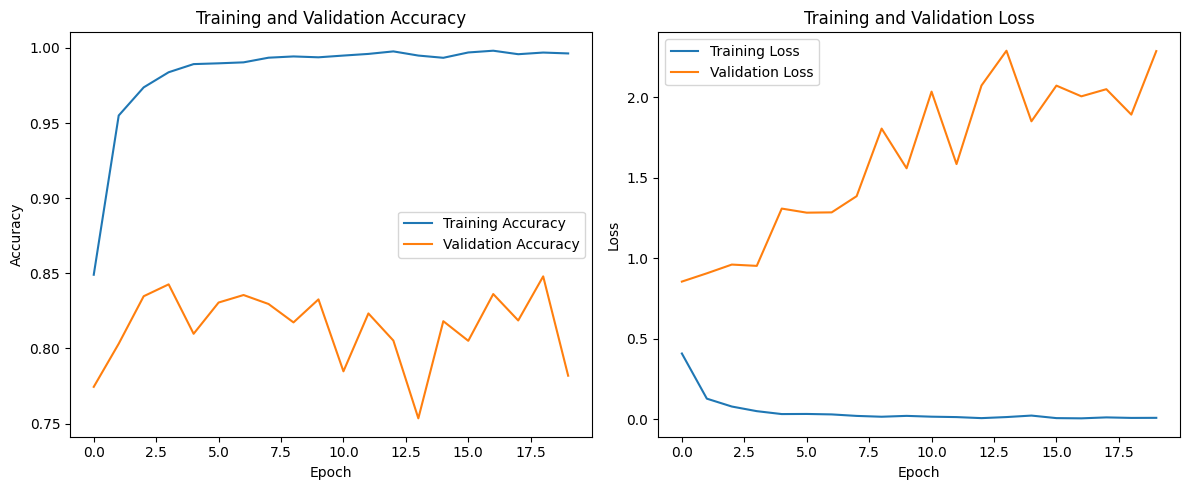

In [12]:
# 정확도 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step


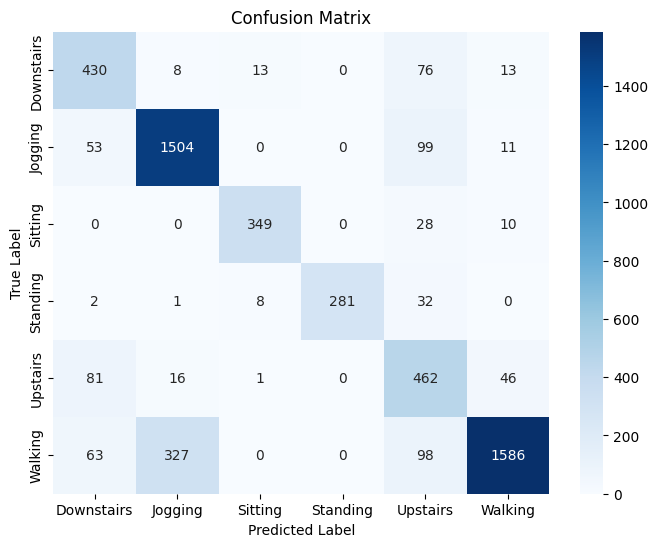


Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.68      0.80      0.74       540
     Jogging       0.81      0.90      0.85      1667
     Sitting       0.94      0.90      0.92       387
    Standing       1.00      0.87      0.93       324
    Upstairs       0.58      0.76      0.66       606
     Walking       0.95      0.76      0.85      2074

    accuracy                           0.82      5598
   macro avg       0.83      0.83      0.82      5598
weighted avg       0.85      0.82      0.83      5598



In [13]:
# 테스트 데이터로 예측
y_pred_onehot = model.predict(X_test_scaled)
y_pred_encoded = np.argmax(y_pred_onehot, axis=1)

# 실제 레이블을 원래대로 복원
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_encoded)

# 혼동 행렬
cm = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 분류 보고서 (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test_original, y_pred_original, target_names=label_encoder.classes_))